In [1]:
from PIL import Image
from torchvision import transforms
from utils import clean_sentences
from attention_model import EncoderCNN, DecoderRNN
import torch
import os
from data_loader import get_loader
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

transform_test = transforms.Compose([transforms.Resize(256),                          # smaller edge of image resized to 256
                                     transforms.CenterCrop(224),                      # get 224x224 crop from random location
                                     transforms.ToTensor(),                           # convert the PIL Image to a tensor
                                     transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                                                          (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test',
                         batch_size=1)


c:\Users\user\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
encoder_file = "add_att_encoder.pt"
decoder_file = "add_att_decoder.pt"

embed_size = 300
hidden_size = 256
encoder_dim = 2048
attention_dim = 1

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)     # type: ignore
# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN()
encoder.eval()
decoder = decoder = DecoderRNN(embed_size, vocab_size, attention_dim, encoder_dim, hidden_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)


DecoderRNN(
  (embedding): Embedding(8852, 300)
  (attention): AdditiveAttention(
    (W_a): Linear(in_features=2048, out_features=256, bias=True)
    (U_a): Linear(in_features=256, out_features=256, bias=True)
    (V_a): Linear(in_features=256, out_features=1, bias=True)
    (_softmax): Softmax(dim=1)
  )
  (lstm_cell): LSTMCell(2348, 256)
  (init_h): Linear(in_features=2048, out_features=256, bias=True)
  (init_c): Linear(in_features=2048, out_features=256, bias=True)
  (fc): Linear(in_features=256, out_features=8852, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)

In [15]:
def get_caption(img_path=None):
    if img_path is not None:
        orig_image = Image.open(img_path).convert("RGB")
        image = transform_test(orig_image).unsqueeze(0)
    else:
        orig_image, image = next(iter(data_loader))
        orig_image = np.squeeze(orig_image)
    
    image = image.to(device)
    features = encoder(image)
    weights, output = decoder.generate_captions(features, data_loader.dataset.vocab)    
    words = clean_sentences(data_loader.dataset.vocab.idx2word, output)     # type: ignore
    plt.imshow(orig_image)
    plt.title(' '.join(words) + '.')

    fig = plt.figure(figsize=(15, 15))
    sentence_length = len(words)

    for i in range(sentence_length):
        temp_att = weights[i].reshape(7, 7).detach().numpy()

        ax = fig.add_subplot(sentence_length//2, sentence_length//2, i+1)
        ax.set_title(words[i])
        img = ax.imshow(orig_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())

    plt.show()
    

Run the code cell below (multiple times, if you like!) to test how this function works.

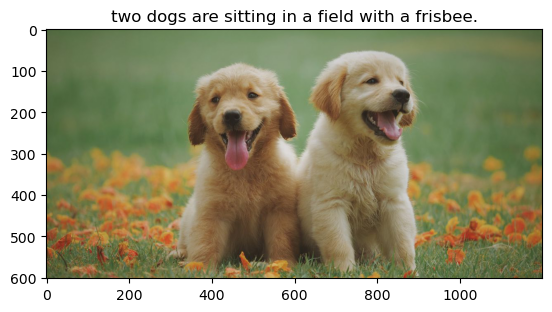

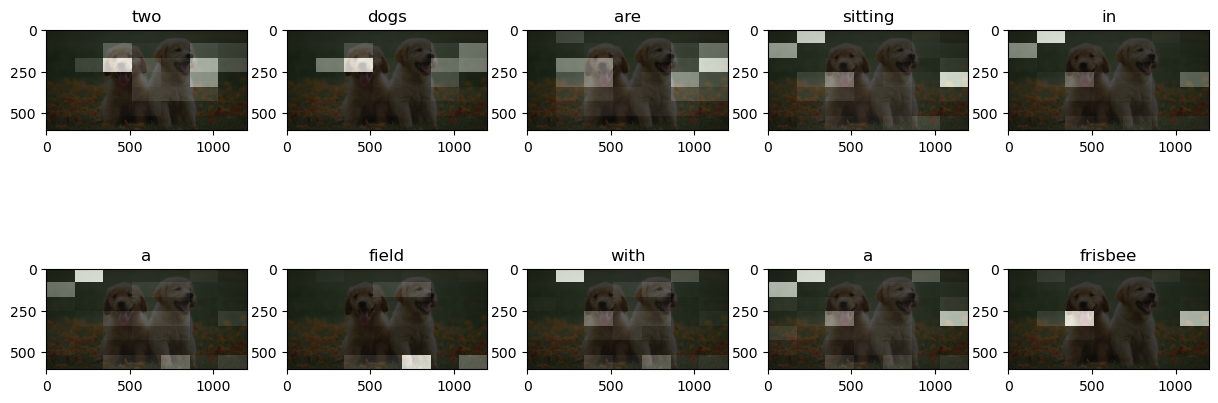

In [16]:
get_caption("images/cute-baby-animals.jpg")


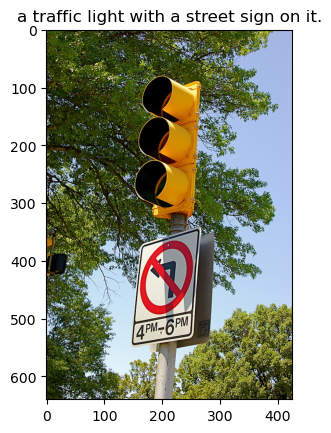

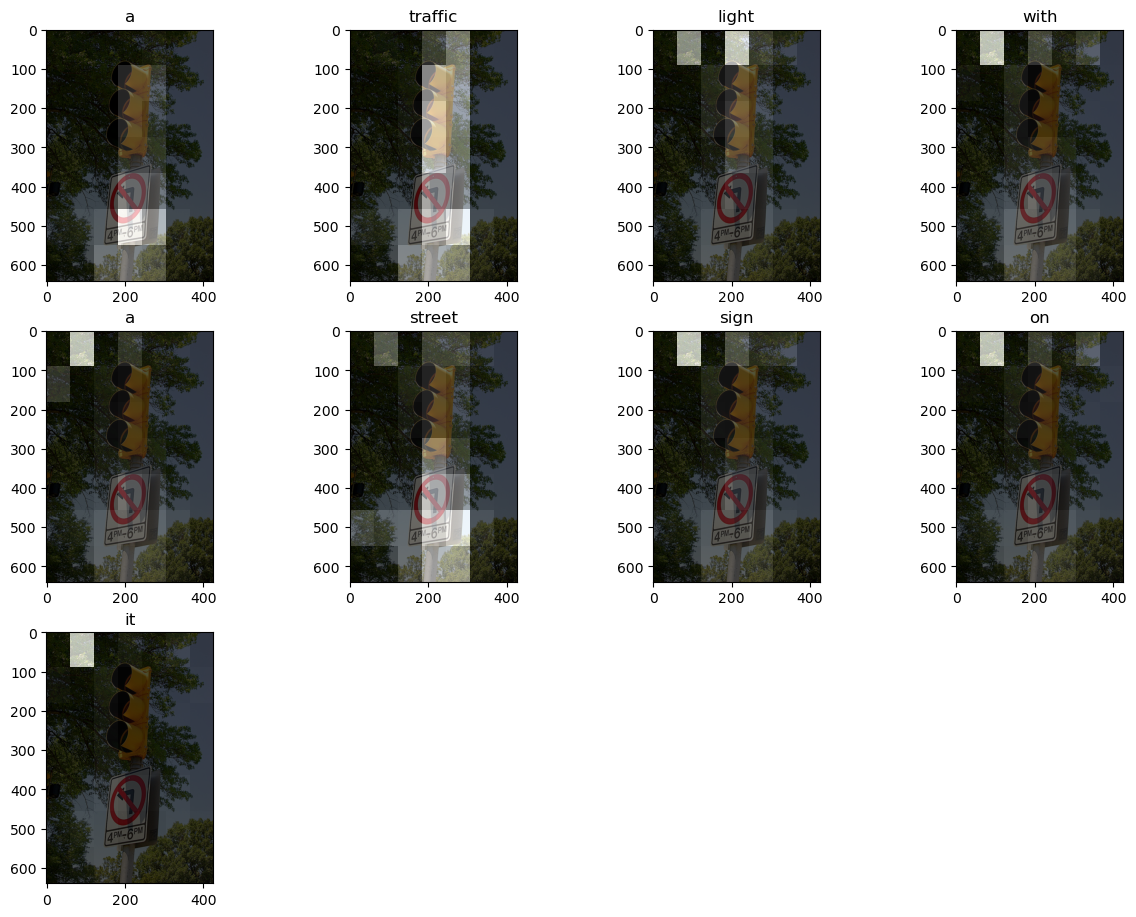

In [17]:
get_caption()